# Q-learning with neural networks

In [1]:
# a few packages we need to import
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 

import torch

import pendulum

import random

# FOR REPRODUCIBILITY
seed = 3

np.random.seed(seed) # NumPy's random number generator
random.seed(seed) # Python's random module
torch.manual_seed(seed) # PyTorch's random number generator

# Behavior in PyTorch
torch.use_deterministic_algorithms(True) # all operations are deterministic

# Consistent floating-point behavior
torch.set_float32_matmul_precision('medium') # control precision
torch.set_default_dtype(torch.float32)  # setting 32-bit float as precision globally

# Setting up device
device = torch.device("cpu")

The goal of this homework is to implement the Q-learning with a neural network for the Q function to solve the inverted pendulum problem.

<img src='pendulum.png' width="120">

In the following, we write $x = \begin{pmatrix} \theta \\ \dot{\theta} \end{pmatrix}$ as the vector of states of the system.

## System dynamics
* The system dynamics is implemented in the `pendulum.py` function. The dynamics is implemented in `pendulum.step`.
* The allowed control inputs are $[-5,0,5]$

## Cost function
The goal is to find a policy that minimizes the following cost
$$\min \sum_{n=0}^N \alpha^n g(x,u)$$
where
$$g(x,v,u) = 0.01*(1-\cos(x-\pi))^2 + 0.001* v^2 + 0.00001*u^2$$
which gives a high cost for states far from $\pi$ (i.e. far from the inverted position) or states with non zero velocity or high controls



## Q-learning algorithm to implement
For each episode:
* Initialize the episode $x_0 = [0,0]$
* For each step of the episode:
    * Select $u_n$ using an $\epsilon$-greedy policy
    * Compute the next state $x_{n+1}$
    * Compute the target $y_n = g(x_n,u_n) + \alpha \min_a Q(x_{n+1},a)$
    * Do one SGD step on the neural network parameters to minimize $(Q(x,u) - y_t)^2$


## Parameters:
* Episode length 100 steps
* Discount factor $\alpha = 0,99$
* Learning rate (for SGD) 0.1
* $\epsilon = 0.1$



## Using PyTorch
You need to install and use PyTorch for the neural network and do the optimization. 

You may want to use the following functions:
* [`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* [`torch.nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

The neural network is given below

In [2]:
## we define the neural network to be used for Q-learning
## 2 hidden layers with 64 nodes
## 2 inputs (state)
## 3 outputs for the 3 possible controls
D_in, H, D_out = 2, 64, 3

q_function = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out)
)

# Sending q_function to device selected
print(f"Device used: {device}")
q_function.to(device)

## we initialize the network parameters to 0
for params in q_function.parameters():
    params = torch.zeros_like(params)


### possible controls
possible_controls = np.array([-5.,0.,5.])

Device used: cpu


# Questions:
1. Implement the Q-learning algorithm described above
2. Test that it works with and without pushes using the code below
3. Plot the cost per episode (to visualize learning)
4. Plot the learned value function (in 2D as a function of pendulum position and velocity) as well as the policy.
5. Describe the algorithm and put the plots in a short report (max 2 pages) and include a video of the pendulum.

## Testing
You can test your results with the code below which use the Q-function to create a controller send to the `animate_robot` function.
You can choose to save also a movie of the animation and toggle the animation with a disturbance.

In [3]:
x0 = np.zeros((2,1))
def controller(x):
    u_pred = torch.argmin(q_function(torch.as_tensor(x, dtype=torch.float).unsqueeze(0))).item()
    u = possible_controls[u_pred]
    return u
    
pendulum.animate_robot(x0,controller,push=False, save_movie=False)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAGfJtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE1
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DQVliIQAEf/+94gfMstp+TrXchHnrS6tH1DuRnFepL3+IAAAAwAAAwACHHgr8h1jA36boAAANaAG
nDnk/0uKTTxANBMklOx5AfoyzTNjGZoxSMjI2XqpG5muyFpkpA6oCAPVnxylzDLYhuV6SiLysV19
ZrkfNVeuuW3Q9PnAIUDhMZl7zUCMeOI9XyhO34h2N6JqaLaBMEJBECZ+5uHUUpUwEyHMK0SddgK8
GQ+8N9YKy9+mi5xcrkYkRWJQER7+UzLKhVSfJl1dCKS9cKV2QpOCIcN2cB6dc7SsaFnK+lNL704K
VLG608M5FPwh6EL0EBwAfACHU1dX1oJZzgeYkF9jIDc1B3hLlj82wiQfYvK10RzuN9Q1U62r1Osc
ElerAZPXIcx/zTPnGxXw5umCITKeSjxzd7a4br1XC57E49S2VekK2ZcoSsDlXM3IXwr8wKVNTmii
S4/b2C6vQHzLa8snanJg+/rHy8lm80ZnrrjDHhzJMv9fPnzZXf6By7qlajFITt+t8f783P8Mz+Tg
usP5W1SLsMI3NM2xEvgKqVlwK5xY60lN12x7Sxb1UVNJQyHZWr/RBporGZP8yOHAwfJClNMX63fD
m8c59mi2E3q6GhztvWsCyOWh5judEAR3Mtt2SCs6HGEaSgYlXuEYHT/GFbYFW7BXW0mAvXEkEOo0
UO9lDqteHlDvCaab1EPQmssAofZbyBtCTx3gEoMqaxYBPT+PMNxp5Id+podG7m25zbFkLGr8sdAd
g3st85YZo+AAAAMAAAMAAAMD5bq668lq1kcb+Tg6aDPsgjyWKDMdD0yHj/5bx7eUJGj6HKNJitPP
bnKAg53ZSs7UshUGYlzIgUjFa1NdjtgYDypQ39bj6qUwv2rHJokH6CjcU+hzyiZesDli2KhPgst/
e3nGm/wOU1Ju0vFwZMbTXrdbC+bV/gOCAdAW7maeFQfieLTr8znIiFAIriEZqnORjIfCmZsjTyKa
m2GBNPBiiunTYYKfcxEjPPWnwawwtU4EDDyMcfy1O9nup++LMOq/+DGJLcJkSGPPhujUA21BEJg4
f0yGqlyVfS+HgCR7nwaYfC+lpb+Plb9PpYhmbE0Ivn/hD/OPtGKoSzzIwKYrYTfPPPQy0IP+p6tZ
tl8wgNEZb5TLNW7Ts0dn2OwYmlf1Pb3pgWTPGII5buScGBOSwryynsEhR/WauHvLQJJEd15vYpdO
DsSq4KAAAAMAAAMAALsxYVhfwEx8kfqcJtLJnIjtbsLLR4KZZltDE9kN06le7f8QSDey6n13doCr
HNLCCZ5Se830xzvr1O9mWEMikfuByvTKE4cqyaIcTpJEdU/TojPRCHFfLj+HuTbLaaRKXm9lukjy
sCpZtRC0MTMf2x+3tLQpyuc2cWmtrn1H00FYc1TZvblP0YzHQDGbcJ35WYcoMM2JvkvhZ0bNHquZ
UFibmALijpNIQhzgPzXx0c1OCf2Ly2Z0lcbRFaSMrk/KIglBjNQ+SkuOpxMwn++t6d06orio+Rt0
rxF0EOz8EGNXM0zXwAvnGCCMKeWs8OdlBKa/i7IzmmfPmvTRPuqup3dqN1NvP/AiYj28piy0hh47
r6pRMzGojI8P+W5aWZx9JdPFv/ggDhFNvngFxotdMzsL+v3HhgMpxVO3fd3xpD6JwBlqnel7/GkB
PrKFyFMikCXHGP6+kyFmH7cQGlK6FeCnrzJr6qSZUS/46CBOjo0LrxY0tWpWm8lSXlL3Louy/+pv
N+IJHcYglXnW8oSGlzYz4wj/TGvAewEaGuDdy4PIBq3/046plAOKMlbMEYVMuPNlJsPU0CTzkIAA
OwAAAwAAMZoD+T76rL/HNkj0KH+VHrQZYw/3sNG8b25cXhoHvzX5gmItrg9e1HuaUgV9ytvQk6nP
hsEjrkRRyB0QbDbwr+cZDY2JkefXqKCfe3noUekGNFvCuyiNvJWHjALguDTvSlIA1gjLNtwe434X
ycNn3hI6onTGauGO9oHhFD2eF6UIQoErn8mVnb+1vxN7i2SmYekeZrGqU4mOEyFxIe0aC5n+HF7J
J23uii0AsSouvJsQu1ozavRsBdn/ySW5NBQDVaCOqKtj/aVw9LufuQhTm/++64yRvSNQ1u+177Vw
SdwP3TNxL6SxYR0iWEaivGA3S2wcvRINrYfq98R7ZgIwTrep45o6q6UuC4q24wnoJUf/R1UBMUr0
6L4nGm20EhPvF/vhURan2pid5B9K0Y+sahIWpASrLku3pXajXmYnZ5Oz5uBRVnQ5xPpkYigXmxeM
Zuw9ZQzxG/+hmaFNtlhZ1XKI30INc92L9Z7lOPMT8dB9I0Lti9Q7P6qcceVU6nfwIBKO9dhC8qfn
XiaOBGSFKfqLCAAAF9AAAAMA6NUUqLEXU8MZDFrRngvpUoeVVau6aQNO7mRFAMWkCNW5EgwnLFRw
fs1Jvnp6g7miBcb35K0Ns4H5WxPldmWLGQC4pGyw66TZJn7X3ZdCNLKYQIPlTb/5VYbvaiskffuP
2+aIDUgjB0bbBKapACqcdC+ISmPv3iX4OX103PxEegpytEMRis5zfpw3PjcQ5T+ef+smJ2D13XIK
K3J57l/0TQT1llGi7OXogOAArxeS5TRw/b2C75FDj1KSaAbSFVApNRgVF3canTuVyC0dmLaL6pKk
C1V79Q/jEbrUUZop+J5I3x/FoZPKg1aw3OuYXK91U6I5/1TtpBK0z7E4UOe15t15eu9AP/+EHoIu
hFUGxvmKgzIc04zaFagtwlEl7pC85UKs2RJmYoONguMvXhqTT3/27WSnRA2jmw+syBdO+Mrw3Ugj
CY2j8soNnoZZgI5ycZSHWRdapY3kb8J8ZVM3HpCMRYYkq77Dpy5ezkHp15iWp6XqfPdbU3EpHEQo
uk0QIFivtkVD4hDpvy19x

In [4]:
# Parameters initialization
episode_length = 100
num_episodes = 17000
alpha = 0.99          # Discount factor
epsilon = 0.1         # Epsilon for epsilon-greedy policy
learning_rate = 0.1   # Learning rate for SGD

# Loss function and optimizer
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(q_function.parameters(), lr=learning_rate)

In [5]:
# Plotting cost per episode
cost_per_episode = []

# Q-learning algorithm implementation
for episode in range(num_episodes):
    # Initializing the episode with x0 = [0, 0]
    x = np.zeros((2,))
    cumulative_cost = 0.0
    cumulative_reward = 0.0

    for step in range(episode_length):
        # Converting state x to tensor
        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)  # Shape - (1, 2)

        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            # Selecting a random action
            action_index = np.random.randint(len(possible_controls))
        else:
            # Selecting action that minimizes Q(x, u)
            with torch.no_grad():
                q_values = q_function(x_tensor)
                action_index = torch.argmin(q_values).item()

        u_n = possible_controls[action_index]

        # Applying action u_n to get x_{n+1}
        x_next = pendulum.step(x, u_n)

        # Computing cost g(x_n, u_n)
        theta = x[0]
        thetadot = x[1]
        cost = 0.01 * (1 - np.cos(theta - np.pi))**2 + 0.001 * thetadot**2 + 0.00001 * u_n**2
        cumulative_cost += cost

        # Computing target y_n = g(x_n, u_n) + alpha * min_a Q(x_{n+1}, a)
        x_next_tensor = torch.tensor(x_next, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values_next = q_function(x_next_tensor)
            min_q_value_next = torch.min(q_values_next, dim=1)[0].item()

        y_n = cost + alpha * min_q_value_next

        # Doing 1 SGD step on (Q(x_n, u_n) - y_n)^2
        optimizer.zero_grad()

        q_values_current = q_function(x_tensor)
        q_value = q_values_current[0, action_index]

        loss = loss_fn(q_value, torch.tensor(y_n, dtype=torch.float32))

        loss.backward()
        optimizer.step()

        # Updating state
        x = x_next

    # Storing cumulative cost for plotting
    cost_per_episode.append(cumulative_cost)

    # Printing progress every 100 episodes
    if (episode + 1) % 500 == 0:
        print(f"Episode {episode + 1}/{num_episodes}, Cumulative Cost: {cumulative_cost:.4f}")

Episode 500/17000, Cumulative Cost: 3.7184
Episode 1000/17000, Cumulative Cost: 0.7219
Episode 1500/17000, Cumulative Cost: 1.0957
Episode 2000/17000, Cumulative Cost: 1.3750
Episode 2500/17000, Cumulative Cost: 0.6927
Episode 3000/17000, Cumulative Cost: 1.1104
Episode 3500/17000, Cumulative Cost: 1.0340
Episode 4000/17000, Cumulative Cost: 1.5632
Episode 4500/17000, Cumulative Cost: 0.7129
Episode 5000/17000, Cumulative Cost: 1.4403
Episode 5500/17000, Cumulative Cost: 1.4833
Episode 6000/17000, Cumulative Cost: 0.7175
Episode 6500/17000, Cumulative Cost: 1.1584
Episode 7000/17000, Cumulative Cost: 1.0757
Episode 7500/17000, Cumulative Cost: 1.2593
Episode 8000/17000, Cumulative Cost: 1.5091
Episode 8500/17000, Cumulative Cost: 0.9831
Episode 9000/17000, Cumulative Cost: 1.1342
Episode 9500/17000, Cumulative Cost: 0.9858
Episode 10000/17000, Cumulative Cost: 1.1502
Episode 10500/17000, Cumulative Cost: 1.0408
Episode 11000/17000, Cumulative Cost: 1.5263
Episode 11500/17000, Cumulativ

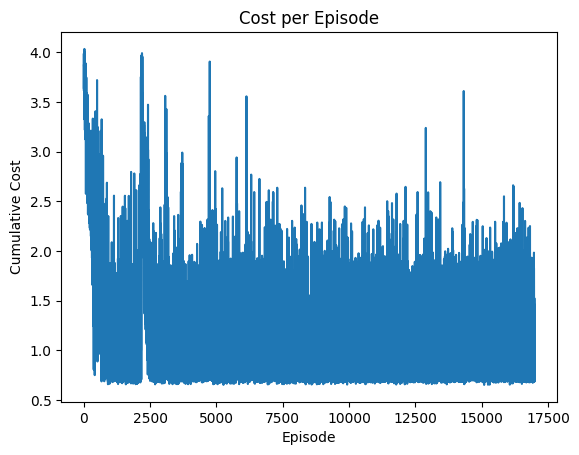

In [6]:
# Plotting the cost per episode
plt.figure()
plt.plot(cost_per_episode)
plt.xlabel('Episode')
plt.ylabel('Cumulative Cost')
plt.title('Cost per Episode')
plt.show()

In [7]:
# Initial state
x0 = np.zeros((2, 1))

# Animating & saving the pendulum without disturbance
pendulum.animate_robot(x0, controller, push=False, save_movie=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAct9tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE1
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DMtliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOONPsPaEewkllXn2fy
1TN9UNOLuVpCg16nA3KBIICjbY2TQND3n5QxoJFUYpmvY7NlYgUyYC0Gbe9iLYzS+7C8JQLMZGRo
QnlmwO88l0TfdHNayNY+bQVlMTywhlcWFi3wo5I9OWpDp/O5o69Dh9VCAAA7ArAJGcKIhsON1YTX
SZ+7DpOh956UxbX9JHiFm0hB1kTY014bpjWhUKbF1FKiZRgAQ7MAQvEwgyGH1uM4k2yJme2NrCEf
1et3jjVSqDCw+r7H/WCFxoXdA3+LIwLQIlEN4vX5b2C+zQHzQ2fvvWqjUq9aNu3EtiYXsnvASOIf
l+rVy9k4jM0fQozkmz686awrq/0JP/wHEZ5HxV6D6ogIfq2IPFjaNM2xEvdPVhQ00IosdtX+BT8h
otcUT/d7qyqyMVichmsEjJf+GSv9KgqH/Qr4wFoCWtHci5Xu+mUn1NauuhWOazymWvlfnp2P8Xtn
rGfqYO8ABZbE2jQvl/bvZyxMzASWpapBIGfgt9jw72WnvnbOSwSOq/95ZL5tztAi6b64LPRAG2PA
7ciJ4kQ8sin3aqMi27TlMAAVgV366T7QAACYAAADAIoiIjH+mqXZG/lzQDiRWJObB82UWs5ijO7q
G8CaMJTPLZiyODEf5WMtQZbidqVbXDgJUGYkcITsrmJ1N90uggGSi6n+gAbRd8Ys19rAaIcHC48A
t6z/lDHg96fyUvBaqi5R4HyY37YL3JOB4uQKR24Vc1Kj64v8BfmbYFu5mnhUH4n9qgrxZyIhQCKE
f2apzkYyHwpmbJ6TeZWRkMgxc4orxwo0Cq/p1VGz1p8GsMLVOBP5wsZ58REFlh3kQCbgOf/LA+DF
XUOi7q0ap03/j4iEwjRfQIhZTR9fNPRNtYz38yMHdzMCnZetf7J9IAJBI2JB7YPsg2mQW2twH5vJ
5m5A8X+ZFiDtz2jOBBM3zw0JVDDaB+Ndhf0SWxxcqRbIiUOGz/R0UZPwpynYIgKubgT//8q9dWcZ
1XEIzxq+aThyf2J0AAADAAADAAAONACcMPAPC0oJiYWT54SJN4MVTlndYVfK30WkW0p13OQFZB0W
rf4Lhw6AhDrJje7rTJtgpSF3RMT/jqtQ4NMtKW6hTu7ztyS8Ls1N/exTblz8bMRWoUVW7xsjI1hO
OhLXh3Q7ZbsDXXpOg2n8WKgy5uLuBlkWlwl4IFu4fJWfM5/pZhq6IoOqf8RNEyA+sjywfpGF6qts
EhBr9yxdiMMf3c1KpmC+bTBfhwXZ5zvTnHY53OH/C64ZfZe2TnwnfXzTjYUhjR0QYae6yOz/qpwH
wPF2OHZdO3RMGmsuAVUdvE7dnM69eNWqSCdTktD6qSIJRrPKJjjrFE/tptjLNJH3cvZ31BwcX30x
1QyyXS5UZVSr9RRBNZ++1JviSn+VQLp5x7hawaICn1meqpwV7ElnMi34CkniyhZdRHf4LJeGie6v
o+Kfl2/P9fccq41gKhtHcIYK47qsSPFEzTBh22NXyJ4CHrua7T+EaEjbOOkNnhYI0enJvUlCAtwj
wGYelc6/6vpId193vtLbIIZkeBNMiigabyG0P/RTZeiYmwVvsHf1QLNh6aA8T6JFbcbyImiDXUYf
ck8IrpWWm1Mcs5vd0gsusT/6K4YCB6pgvKQAIPEGZxqD0OanZib80E77/2sxn3TH6dUnUyrpEga2
DQh1+GbVyLvGOWbm9KTmElzsF34+ffC11rIp6HuydA9iym+5fUMEmdaWSAqyu1LBUpC8sLZXA7cp
5DH2GhhWuEtLsb6lKxv28vsTkno3PbPn5d4jdOKnJfoC1jzm0rLu+sn5R2pX3UpNQ17E48sqQTF3
qkXZVsnFjTmXa7Ff20W5v148q82+wY2Zus33XZuUxrNIGHXSAJUDQ/qHp3p62EQB+m0WfEDjmtDQ
btoLDMAOa2VPjBo6W/z7fPcw7hRsdFcwxhW4oCjNnfecbTih8lfW24cNHE4tTKwrJvK4YQFgOtpy
+yr1BVsFaCNPgmGq2pnZ5jBIStCHvBR/6XClVvan4T/UC80HiA4BZZzeUkc/tjvfXFJx/krGQGW9
ifpm1xCACxExkIThoBZViTeU40560jGkLpjhJcaa4iUoMyAa5iDYP0q9rpGcQwTxEHwn/jJVMpaT
bgfyCz2+2kPIQ29hVg7FjWKQfg1842+vfXyuPaeGMNoMDF9x5ptfrugABdfRhIXqYAPE5LN26Rj1
sAICBHKQABZWDLr7humIdbYE98qUgCAtMgklawcGeC+lSh5YUvc0R3BAtMZ7Qta2qhcN1Z8VO8jH
rQGcm+enqDuaIFxwMtf2ga3e2kEZn5p+xQuSLPf3hlTdhifUSLRuFRIgtJfk80/4xfACDmWSggGu
ukBxn9morYiwD/DR49H9pZsi1H8mWSUamwIiY0gtdzl28CbxJ+9613PkYznDVbHy6cjURHpb/89M
S4mVSZWKm3DpzBdwTpWo1d1kMEzUX1pIfCuQWffbNDAGSpAoqnfqH8YjdaijM2UqYPVHCFMRNI3w
TsysQsxzL3VTojn/VO1+vOCx4dBVMl9O2PG4CfxB/upI27UuZR2n4bcEUHNFpzGRApPy54iQPxAq
6lpXgtayv3NYLjL14akwV/tc0nRajqtnRwdDhmXNmI2uhCWVtPL6XYcWVdz5W7Ul2U1MOWJWefPA
eT1EBDXMeLry3DamEQCi7TA61pjxgbakaNv54ZjqUfLMb3DnXc407Sa94spIVCTxQ3gPVgWLqLFg
e+hXN/FflzPWmMO7ZbouJ

In [8]:
# Animating & saving the pendulum with disturbance
pendulum.animate_robot(x0, controller, push=True, save_movie=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAArxVtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE1
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DMtliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOONPsPaEewkllXn2fy
1TN9UNOLuVpCg16nA3KBIICjbY2TQND3n5QxoJFUYpmvY7NlYgUyYC0Gbe9iLYzS+7C8JQLMZGRo
QnlmwO88l0TfdHNayNY+bQVlMTywhlcWFi3wo5I9OWpDp/O5o69Dh9VCAAA7ArAJGcKIhsON1YTX
SZ+7DpOh956UxbX9JHiFm0hB1kTY014bpjWhUKbF1FKiZRgAQ7MAQvEwgyGH1uM4k2yJme2NrCEf
1et3jjVSqDCw+r7H/WCFxoXdA3+LIwLQIlEN4vX5b2C+zQHzQ2fvvWqjUq9aNu3EtiYXsnvASOIf
l+rVy9k4jM0fQozkmz686awrq/0JP/wHEZ5HxV6D6ogIfq2IPFjaNM2xEvdPVhQ00IosdtX+BT8h
otcUT/d7qyqyMVichmsEjJf+GSv9KgqH/Qr4wFoCWtHci5Xu+mUn1NauuhWOazymWvlfnp2P8Xtn
rGfqYO8ABZbE2jQvl/bvZyxMzASWpapBIGfgt9jw72WnvnbOSwSOq/95ZL5tztAi6b64LPRAG2PA
7ciJ4kQ8sin3aqMi27TlMAAVgV366T7QAACYAAADAIoiIjH+mqXZG/lzQDiRWJObB82UWs5ijO7q
G8CaMJTPLZiyODEf5WMtQZbidqVbXDgJUGYkcITsrmJ1N90uggGSi6n+gAbRd8Ys19rAaIcHC48A
t6z/lDHg96fyUvBaqi5R4HyY37YL3JOB4uQKR24Vc1Kj64v8BfmbYFu5mnhUH4n9qgrxZyIhQCKE
f2apzkYyHwpmbJ6TeZWRkMgxc4orxwo0Cq/p1VGz1p8GsMLVOBP5wsZ58REFlh3kQCbgOf/LA+DF
XUOi7q0ap03/j4iEwjRfQIhZTR9fNPRNtYz38yMHdzMCnZetf7J9IAJBI2JB7YPsg2mQW2twH5vJ
5m5A8X+ZFiDtz2jOBBM3zw0JVDDaB+Ndhf0SWxxcqRbIiUOGz/R0UZPwpynYIgKubgT//8q9dWcZ
1XEIzxq+aThyf2J0AAADAAADAAAONACcMPAPC0oJiYWT54SJN4MVTlndYVfK30WkW0p13OQFZB0W
rf4Lhw6AhDrJje7rTJtgpSF3RMT/jqtQ4NMtKW6hTu7ztyS8Ls1N/exTblz8bMRWoUVW7xsjI1hO
OhLXh3Q7ZbsDXXpOg2n8WKgy5uLuBlkWlwl4IFu4fJWfM5/pZhq6IoOqf8RNEyA+sjywfpGF6qts
EhBr9yxdiMMf3c1KpmC+bTBfhwXZ5zvTnHY53OH/C64ZfZe2TnwnfXzTjYUhjR0QYae6yOz/qpwH
wPF2OHZdO3RMGmsuAVUdvE7dnM69eNWqSCdTktD6qSIJRrPKJjjrFE/tptjLNJH3cvZ31BwcX30x
1QyyXS5UZVSr9RRBNZ++1JviSn+VQLp5x7hawaICn1meqpwV7ElnMi34CkniyhZdRHf4LJeGie6v
o+Kfl2/P9fccq41gKhtHcIYK47qsSPFEzTBh22NXyJ4CHrua7T+EaEjbOOkNnhYI0enJvUlCAtwj
wGYelc6/6vpId193vtLbIIZkeBNMiigabyG0P/RTZeiYmwVvsHf1QLNh6aA8T6JFbcbyImiDXUYf
ck8IrpWWm1Mcs5vd0gsusT/6K4YCB6pgvKQAIPEGZxqD0OanZib80E77/2sxn3TH6dUnUyrpEga2
DQh1+GbVyLvGOWbm9KTmElzsF34+ffC11rIp6HuydA9iym+5fUMEmdaWSAqyu1LBUpC8sLZXA7cp
5DH2GhhWuEtLsb6lKxv28vsTkno3PbPn5d4jdOKnJfoC1jzm0rLu+sn5R2pX3UpNQ17E48sqQTF3
qkXZVsnFjTmXa7Ff20W5v148q82+wY2Zus33XZuUxrNIGHXSAJUDQ/qHp3p62EQB+m0WfEDjmtDQ
btoLDMAOa2VPjBo6W/z7fPcw7hRsdFcwxhW4oCjNnfecbTih8lfW24cNHE4tTKwrJvK4YQFgOtpy
+yr1BVsFaCNPgmGq2pnZ5jBIStCHvBR/6XClVvan4T/UC80HiA4BZZzeUkc/tjvfXFJx/krGQGW9
ifpm1xCACxExkIThoBZViTeU40560jGkLpjhJcaa4iUoMyAa5iDYP0q9rpGcQwTxEHwn/jJVMpaT
bgfyCz2+2kPIQ29hVg7FjWKQfg1842+vfXyuPaeGMNoMDF9x5ptfrugABdfRhIXqYAPE5LN26Rj1
sAICBHKQABZWDLr7humIdbYE98qUgCAtMgklawcGeC+lSh5YUvc0R3BAtMZ7Qta2qhcN1Z8VO8jH
rQGcm+enqDuaIFxwMtf2ga3e2kEZn5p+xQuSLPf3hlTdhifUSLRuFRIgtJfk80/4xfACDmWSggGu
ukBxn9morYiwD/DR49H9pZsi1H8mWSUamwIiY0gtdzl28CbxJ+9613PkYznDVbHy6cjURHpb/89M
S4mVSZWKm3DpzBdwTpWo1d1kMEzUX1pIfCuQWffbNDAGSpAoqnfqH8YjdaijM2UqYPVHCFMRNI3w
TsysQsxzL3VTojn/VO1+vOCx4dBVMl9O2PG4CfxB/upI27UuZR2n4bcEUHNFpzGRApPy54iQPxAq
6lpXgtayv3NYLjL14akwV/tc0nRajqtnRwdDhmXNmI2uhCWVtPL6XYcWVdz5W7Ul2U1MOWJWefPA
eT1EBDXMeLry3DamEQCi7TA61pjxgbakaNv54ZjqUfLMb3DnXc407Sa94spIVCTxQ3gPVgWLqLFg
e+hXN/FflzPWmMO7ZbouJ

In [9]:
# Creating a grid of theta and thetadot values
theta_vals = np.linspace(-np.pi, np.pi, 100)
thetadot_vals = np.linspace(-10, 10, 100)
Theta, Thetadot = np.meshgrid(theta_vals, thetadot_vals)

# Flattening grid arrays
theta_flat = Theta.flatten()
thetadot_flat = Thetadot.flatten()

# Creating state tensor
x_states = np.vstack((theta_flat, thetadot_flat)).T
x_tensor = torch.tensor(x_states, dtype=torch.float32)

# Computing Q-values for all states
with torch.no_grad():
    q_values = q_function(x_tensor)
    min_q_values, actions = torch.min(q_values, dim=1)

# Reshaping results back to grid shape
Value_function = min_q_values.numpy().reshape(Theta.shape)
Policy_indices = actions.numpy().reshape(Theta.shape)
Policy = possible_controls[Policy_indices]

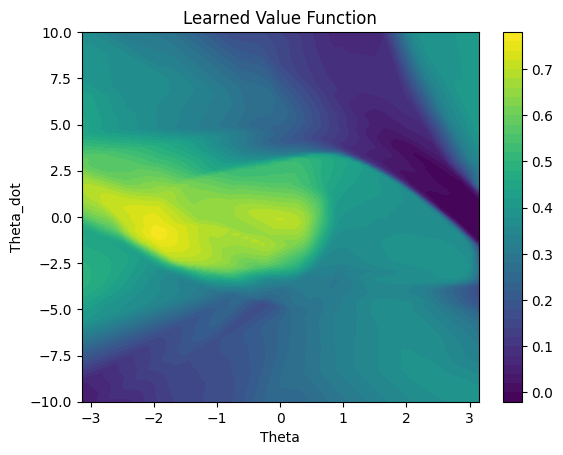

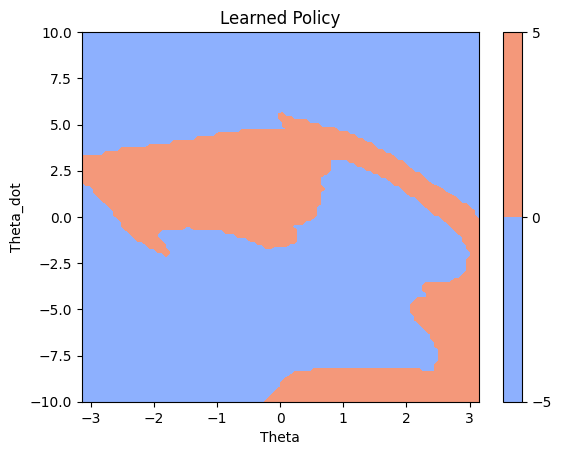

In [10]:
# Plotting learned value function
plt.figure()
plt.contourf(Theta, Thetadot, Value_function, levels=50, cmap='viridis')
plt.colorbar()
plt.xlabel('Theta')
plt.ylabel('Theta_dot')
plt.title('Learned Value Function')
plt.show()

# Plotting learned policy
plt.figure()
plt.contourf(Theta, Thetadot, Policy, levels=possible_controls, cmap='coolwarm')
plt.colorbar(ticks=possible_controls)
plt.xlabel('Theta')
plt.ylabel('Theta_dot')
plt.title('Learned Policy')
plt.show()